<a href="https://colab.research.google.com/github/matthewpolanco/FakeNewsClassification/blob/main/CS_767_Matthew_Polanco_Term_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Matthew Polanco
Class: CS 767
Date: 4/27/22
Term Project:
Classify political text into real and fake news
"""

# IMPORT LIBRARIES AND DATASETS

In [1]:
#!pip install nltk
#!pip install WordCloud
#!pip install gensim # Gensim is an open-source library for NLP
#!pip install bioinfokit

import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from wordcloud import ImageColorGenerator
from PIL import Image
import re
import nltk
from nltk.util import ngrams
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import word_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM
from tensorflow.keras.models import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load the data
fake_news = pd.read_csv("/content/drive/MyDrive/Term_Project_Dataset/Fake.csv")
real_news = pd.read_csv("/content/drive/MyDrive/Term_Project_Dataset/True.csv")

# DATA SETUP

In [4]:
# add a target class column to indicate whether the news is real or fake
real_news['isReal'] = 1
real_news.head()

,title,text,subject,date,isReal
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [5]:
fake_news['isReal'] = 0
fake_news.head()

,title,text,subject,date,isReal
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [6]:
# Concatenate Real and Fake News
data = pd.concat([real_news, fake_news]).reset_index(drop = True)
data

,title,text,subject,date,isReal
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [7]:
data.drop(columns = ['date'], inplace = True)

In [8]:
# combine title and text together
data['document'] = data['title'] + ' ' + data['text']
data.head()

,title,text,subject,isReal,document
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


In [9]:
data['document'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

# TEXT PREPROCESSING

In [10]:
def preprocess_text(text):
    '''Make text lowercase, remove punctuation and stopwords, lemmatize words.'''
    lm = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and token not in stop_words and len(token) > 3:
            token = lm.lemmatize(token)
            result.append(token)

    return result

In [11]:
data['clean_tokenized_document']=data['document'].apply(lambda x:preprocess_text(x))

In [12]:
data['clean_tokenized_document'][0][:5]

['budget', 'fight', 'loom', 'republican', 'flip']

In [13]:
data['clean_document'] = data['clean_tokenized_document'].apply(lambda x: " ".join(x))

In [14]:
data['clean_document'][0]

'budget fight loom republican flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cut called fiscal conservative sunday urged budget restraint keeping sharp pivot republican representative mark meadow speaking face nation drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy november congressional election campaign approach republican seek control congress president donald trump republican want budget increase military spending democrat want proportional increase defense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadow chairman small influential house freedom caucus said program democrat saying need government raise percent fiscal con

In [15]:
total_words = []
for i in data.clean_tokenized_document:
    for j in i:
        total_words.append(j)
len(total_words)

9278699

In [16]:
total_words = len(list(set(total_words)))
total_words

100980

# EXPLORATORY DATA ANALYSIS

In [17]:
data

,title,text,subject,isReal,document,clean_tokenized_document,clean_document
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, loom, republican, flip, fiscal...",budget fight loom republican flip fiscal scrip...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruit, monda...",military accept transgender recruit monday pen...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, want, postal, service, charge, amazon,...",trump want postal service charge amazon shipme...
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settle, mail, privacy, class,...",justice yahoo settle mail privacy class action...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally call quit...


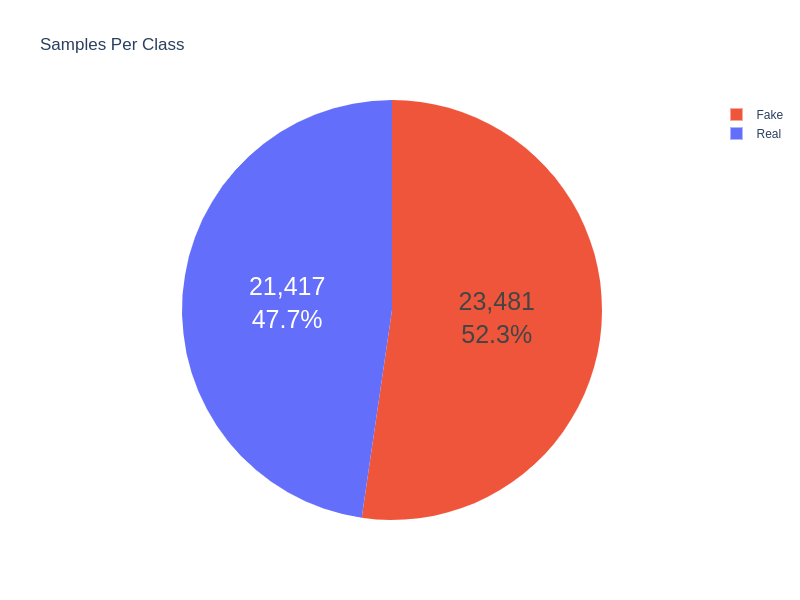

In [288]:
fig = px.pie(data, values = data.groupby(['isReal'])['isReal'].count().sort_values(ascending=False), names=['Fake', 'Real'],
             color_discrete_sequence=["#EF553B", "#636EFA"] ,title='Samples Per Class')
fig.update_traces(textinfo='value+percent', textfont_size=25)
fig.update_layout(height=600, width=800)
fig.show('png')

In [19]:
def ngram_analysis(n, news_type):
  if news_type == 'real':
    news = data[data['isReal']==1]
  elif news_type == 'fake':
    news = data[data['isReal']==0]
  else:
    news = data

  list_of_words = []
  for document in news.clean_document:
    tokens = nltk.word_tokenize(document)
    list_of_words.append(tokens)

  list_of_words = [item for sublist in list_of_words for item in sublist]

  ngram = (pd.Series(nltk.ngrams(list_of_words, n)).value_counts())[:10]

  return pd.DataFrame(ngram)

In [284]:
def create_plots(data, ngram):
  real_data = ngram_analysis(ngram, 'real')
  fake_data = ngram_analysis(ngram, 'fake')

  real_data = real_data.to_dict('split')
  fake_data = fake_data.to_dict('split')

  real_data.pop("columns")
  fake_data.pop("columns")

  if ngram == 1:
    real_data = {str(real_data['index'][i][0]): real_data['data'][i][0] for i in range(len(real_data['index']))}
    fake_data = {str(fake_data['index'][i][0]): fake_data['data'][i][0] for i in range(len(fake_data['index']))}
  else:
    real_data = {str(real_data['index'][i]): real_data['data'][i][0] for i in range(len(real_data['index']))}
    fake_data = {str(fake_data['index'][i]): fake_data['data'][i][0] for i in range(len(fake_data['index']))}

  trace1 = go.Bar(x = list(real_data.keys()), y = list(real_data.values()), name='Real News',
                  marker=dict(color = list(real_data.values()), colorscale='blues'))
  trace2 = go.Bar(x = list(fake_data.keys()), y = list(fake_data.values()), name='Fake News',
                  marker=dict(color = list(real_data.values()), colorscale='reds'))

  fig = make_subplots(rows=2, cols=1)

  fig.append_trace(trace1, 1,1)
  fig.append_trace(trace2, 2, 1)

  fig.update_layout(height=600, width=800, title_text="Top 10 " + str(ngram) + "-Grams From Each News")

  fig.show('png')

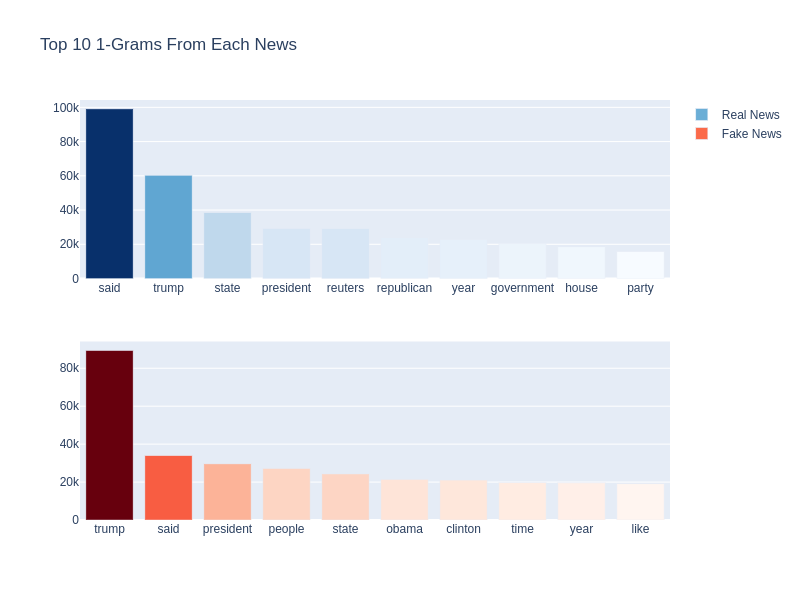

In [285]:
create_plots(data, 1)

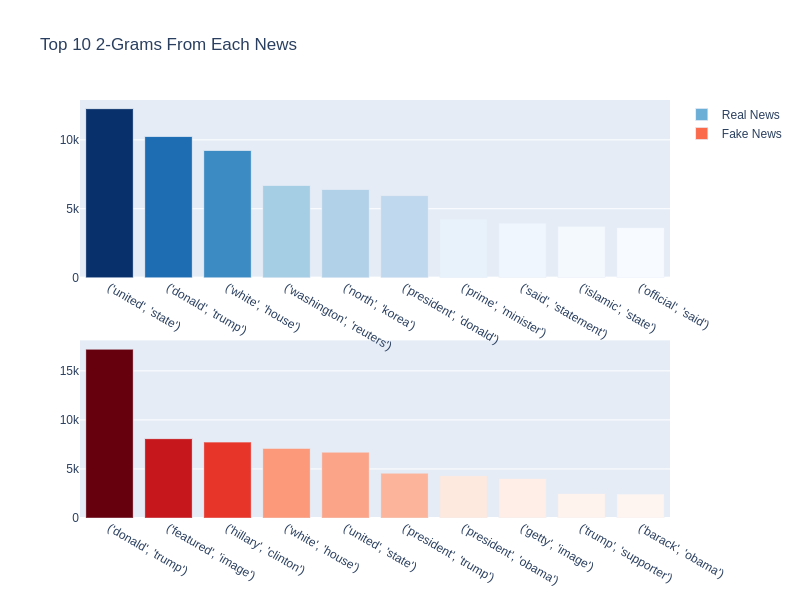

In [286]:
create_plots(data, 2)

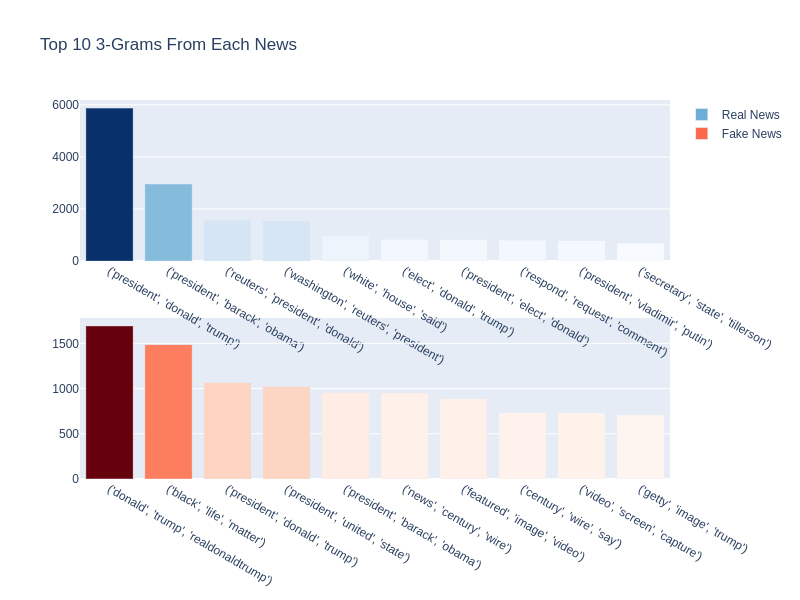

In [287]:
create_plots(data, 3)

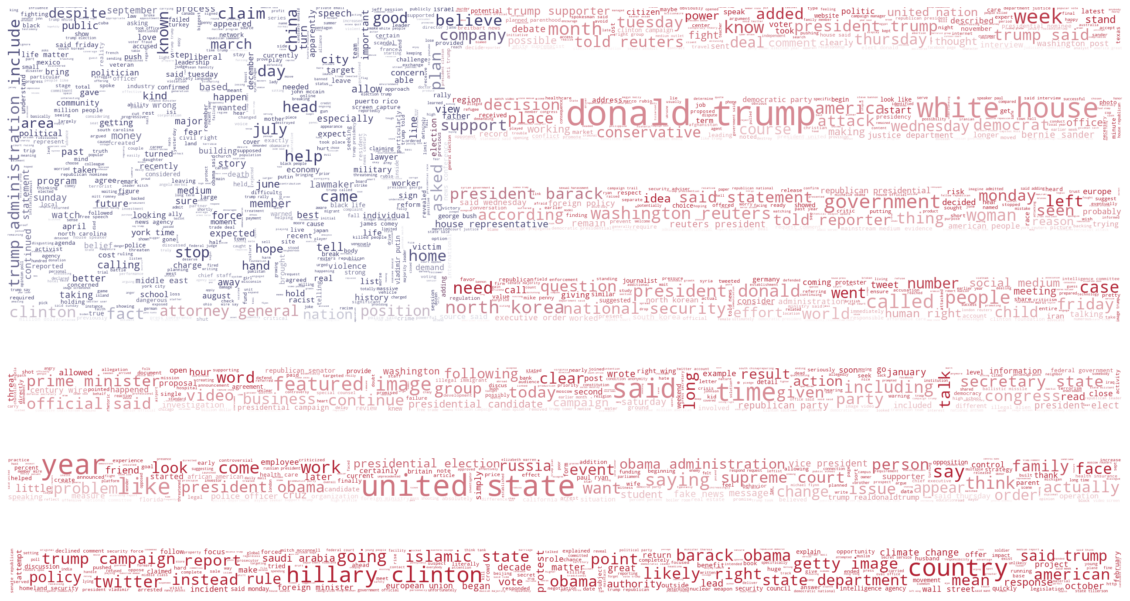

In [24]:
mask = np.array(Image.open("/content/drive/MyDrive/Term_Project_Dataset/usa_flag.png"))
plt.figure(figsize = (20,20))
image_colors = ImageColorGenerator(mask) 
wc = WordCloud(stopwords=stopwords.words('english'),
               mask=mask, background_color="white",
               max_words=2000, random_state=42, 
               width=mask.shape[1], height=mask.shape[0],
               color_func=image_colors)
wc.generate(" ".join(data.clean_document))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [25]:
# length of longest document will be needed to create word embeddings 
max_length = 0
for document in data.clean_document:
    tokens = nltk.word_tokenize(document)
    if(max_length < len(tokens)):
        max_length = len(tokens)
print("Max number of words in any document:", max_length)

Max number of words in any document: 4406


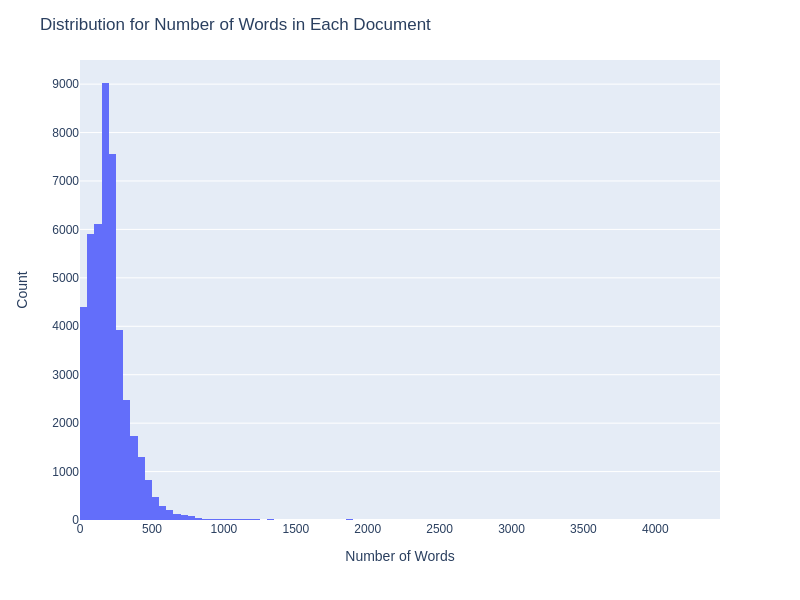

In [283]:
# visualize the distribution of number of words in a document
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in data.clean_document], nbins = 100)
fig.update_layout(height=600, width=800, title="Distribution for Number of Words in Each Document", xaxis_title="Number of Words", yaxis_title="Count")
fig.show('png')

# SENTIMENT ANALYSIS

In [27]:
from textblob import TextBlob

In [35]:
def polarity(x):
    return TextBlob(x).polarity 

def subjectivity(x):
    return TextBlob(x).subjectivity

In [36]:
data['polarity'] = data['clean_document'].apply(polarity)
data['subjectivity'] = data['clean_document'].apply(subjectivity)

In [37]:
data

,title,text,subject,isReal,document,clean_tokenized_document,clean_document,polarity,subjectivity
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, loom, republican, flip, fiscal...",budget fight loom republican flip fiscal scrip...,-0.007124,0.404435
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruit, monda...",military accept transgender recruit monday pen...,0.057674,0.301593
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...,0.158036,0.381964
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...,0.001214,0.217429
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, want, postal, service, charge, amazon,...",trump want postal service charge amazon shipme...,-0.005208,0.410417
...,...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...,0.038548,0.442965
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settle, mail, privacy, class,...",justice yahoo settle mail privacy class action...,0.107143,0.573810
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...,0.055902,0.403440
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally call quit...,0.063636,0.457323


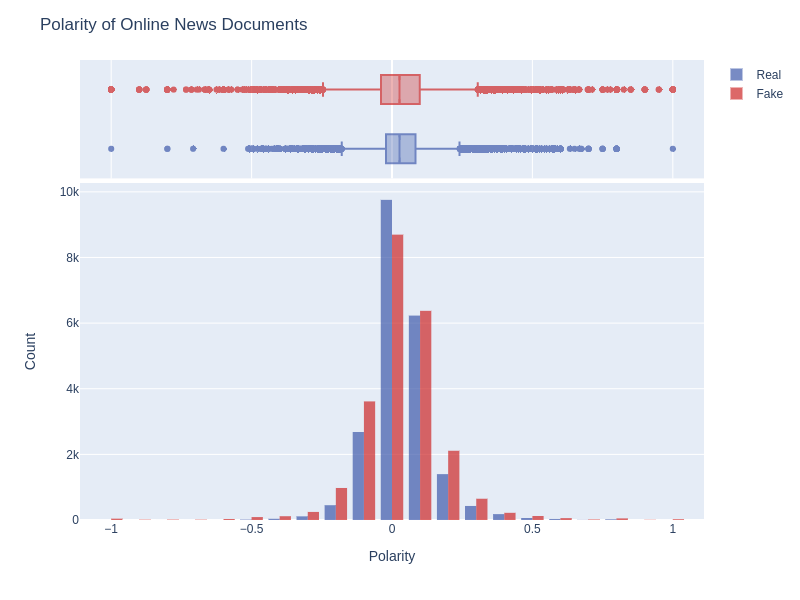

In [289]:
sub = data.copy()
sub['Label'] = np.where(sub['isReal'] == 1, 'Real', 'Fake')
fig = px.histogram(sub, x="polarity", color = 'Label', color_discrete_sequence = ['#3D59AB','#CD2626'], nbins=21, marginal="box", labels = {'Label':''})
fig.update_traces(opacity=0.70)
fig.update_layout(barmode='group')
fig.update_layout(height=600, width=800, title_text="Polarity of Online News Documents", xaxis_title="Polarity", yaxis_title="Count")
fig.show('png')

In [265]:
from bioinfokit.analys import stat

subset = sub.sample(n=10000)

res = stat()
# T-test for difference in means
res.ttest(df=subset, xfac="Label", res="polarity", test_type=2, evar=False)
print(res.summary)

## The p value obtained from the two sided t-test is significant (p > 0.05). 
## Therefore, we cannot conclude that the polarity of Real News is significantly different than polarity of Fake News.




Two sample t-test with unequal variance (Welch's t-test)

------------------  -------------
Mean diff             -0.00390967
t                     -1.45783
Std Error              0.00268183
df                  9133.95
P-value (one-tail)     0.0724606
P-value (two-tail)     0.144921
Lower 95.0%           -0.00916666
Upper 95.0%            0.00134733
------------------  -------------

Parameter estimates

Level      Number       Mean    Std Dev    Std Error    Lower 95.0%    Upper 95.0%
-------  --------  ---------  ---------  -----------  -------------  -------------
Fake         5193  0.0305801   0.15854    0.00220004      0.0262671      0.0348931
Real         4807  0.0344897   0.106331   0.00153364      0.0314831      0.0374964



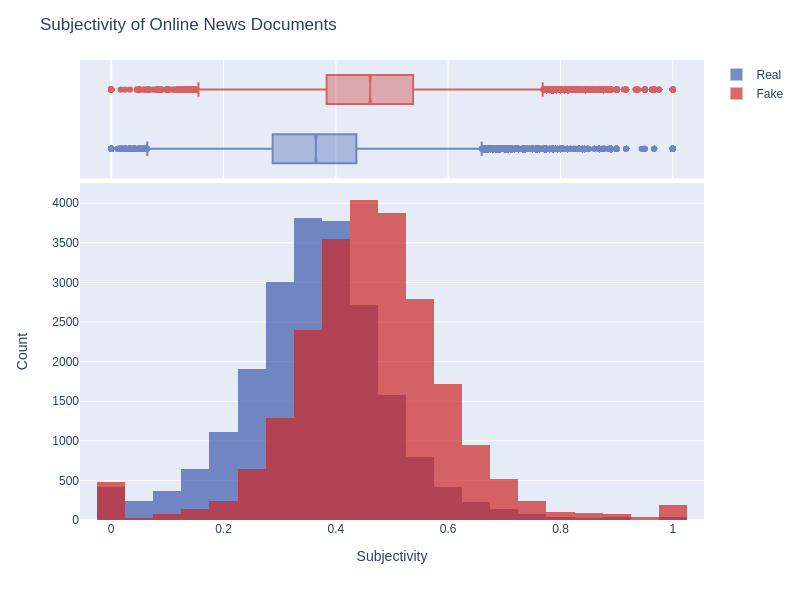

In [290]:
fig = px.histogram(sub, x="subjectivity", color = 'Label', color_discrete_sequence = ['#3D59AB','#CD2626'], nbins= 30, marginal="box", labels = {'Label':''})
fig.update_traces(opacity=0.70)
fig.update_layout(barmode='overlay')
fig.update_layout(height=600, width=800, title_text="Subjectivity of Online News Documents", xaxis_title="Subjectivity", yaxis_title="Count")
fig.show('png')

In [266]:
res.ttest(df=subset, xfac="Label", res="subjectivity", test_type=2, evar=False)
print(res.summary)
## The p value obtained from the one sided t-test is significant (p < 0.05). 
## Therefore, we conclude that the subjectivity of Fake News is significantly higher than subjectivity of Real News.




Two sample t-test with unequal variance (Welch's t-test)

------------------  ---------------
Mean diff              0.100633
t                     35.5442
Std Error              0.00283121
df                  9992.01
P-value (one-tail)     5.52096e-261
P-value (two-tail)     1.10419e-260
Lower 95.0%            0.0950832
Upper 95.0%            0.106183
------------------  ---------------

Parameter estimates

Level      Number      Mean    Std Dev    Std Error    Lower 95.0%    Upper 95.0%
-------  --------  --------  ---------  -----------  -------------  -------------
Fake         5193  0.461819   0.148747   0.00206414       0.457773       0.465866
Real         4807  0.361187   0.134353   0.0019378        0.357388       0.364985



# MODEL 1: TF-IDF & Naive Bayes

In [267]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [268]:
vectorizer = TfidfVectorizer()

In [278]:
# split data into test and train 
x_train1, x_test1, y_train1, y_test1 = train_test_split(data.clean_document, data.isReal, test_size = 0.2)

In [279]:
x_train_tf_idf = vectorizer.fit_transform(x_train1)
dic_vocabulary1 = vectorizer.vocabulary_

In [271]:
x_test_tf_idf = vectorizer.transform(x_test1)

In [272]:
nb_classifier = MultinomialNB()
nb_classifier.fit(x_train_tf_idf, y_train1)

MultinomialNB()

In [273]:
pred1 = nb_classifier.predict(x_test_tf_idf)

In [274]:
accuracy1 = accuracy_score(list(y_test1), pred1)
print("Naive Bayes Model Accuracy : ", accuracy1)

Naive Bayes Model Accuracy :  0.9307349665924276


In [275]:
print(classification_report(y_test1, pred1, target_names=['Fake', 'Real']))

              precision    recall  f1-score   support

        Fake       0.92      0.94      0.93      4712
        Real       0.94      0.92      0.93      4268

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



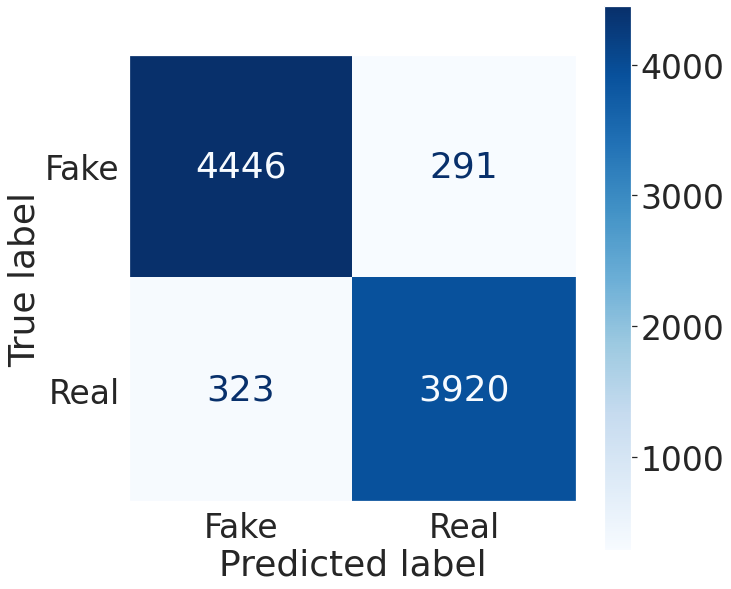

In [ ]:
sns.set(font_scale=3)
cm = confusion_matrix(list(y_test1), pred1)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Fake','Real'])
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap = 'Blues')
plt.grid(b=None)
plt.show()

# MODEL 2: WORD2VEC & LSTM

In [ ]:
# split data into test and train 
x_train2, x_test2, y_train2, y_test2 = train_test_split(data.clean_tokenized_document, data.isReal, test_size = 0.2)

In [ ]:
## fit w2v
w2v = gensim.models.word2vec.Word2Vec(x_train2, size=200, window=5, min_count=5, sg=1)

In [ ]:
## MUST DO TOKENIZING AND PADDING TO GET INPUT DATA READY FOR NEURAL NETWORK
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train2)
dic_vocabulary2 = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(x_train2)
test_sequences = tokenizer.texts_to_sequences(x_test2)

In [ ]:
print("The encoding for document\n",data.clean_document[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight loom republican flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cut called fiscal conservative sunday urged budget restraint keeping sharp pivot republican representative mark meadow speaking face nation drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy november congressional election campaign approach republican seek control congress president donald trump republican want budget increase military spending democrat want proportional increase defense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadow chairman small influential house freedom caucus said program democrat saying need governmen

In [ ]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 50 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 50, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 50, truncating = 'post') 

In [ ]:
### Used from word2vec tutorial: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary2)+1, 200))
for word,idx in dic_vocabulary2.items():
    ## update the row with vector
    try:
        embeddings[idx] =  w2v[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [ ]:
# total words in our vocabulary
embeddings.shape[0]

92022

In [ ]:
# dimension w2v embedding reduced to
embeddings.shape[1]

200

In [ ]:
# Sequential Model
LSTM_model = Sequential(name='LSTM')

# Embedding layer - will use weights learned from w2v
LSTM_model.add(Embedding(input_dim = embeddings.shape[0],
                    output_dim = embeddings.shape[1],
                    weights = [embeddings]))

# LSTM Layer
LSTM_model.add((LSTM(128)))

# Dense layers
LSTM_model.add(Dense(128, activation = 'relu'))
LSTM_model.add(Dense(1,activation= 'sigmoid'))
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
LSTM_model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         18404400  
                                                                 
 lstm_1 (LSTM)               (None, 128)               168448    
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18,589,489
Trainable params: 18,589,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model
LSTM_history = LSTM_model.fit(padded_train, y_train2, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 10s 17ms/step - loss: 0.1950 - acc: 0.9096 - val_loss: 0.0057 - val_acc: 0.9992
Epoch 2/2
506/506 [==============================] - 8s 16ms/step - loss: 0.0062 - acc: 0.9988 - val_loss: 0.0265 - val_acc: 0.9958


In [ ]:
# Save best model, already saved and included in zip file
#LSTM_model.save("/content/drive/MyDrive/Term_Project_Dataset/LSTM_model.h5")
#np.save('/content/drive/MyDrive/Term_Project_Dataset/LSTM_history.npy', LSTM_history.history)

In [ ]:
# Load best model
LSTM_model = keras.models.load_model("/content/drive/MyDrive/Term_Project_Dataset/LSTM_model.h5")
LSTM_history = np.load('/content/drive/MyDrive/Term_Project_Dataset/LSTM_history.npy',allow_pickle='TRUE').item()

In [ ]:
# make prediction
pred2 = LSTM_model.predict(padded_test)

In [ ]:
# if the predicted value is >0.5 it is real else it is fake
prediction2 = []
for i in range(len(pred2)):
    if pred2[i].item() > 0.5:
        prediction2.append(1)
    else:
        prediction2.append(0)

In [ ]:
accuracy2 = accuracy_score(list(y_test2), prediction2)
print("LSTM Model Accuracy : ", accuracy2)

LSTM Model Accuracy :  0.9790645879732739


In [ ]:
print(classification_report(y_test2, prediction2, target_names=['Fake', 'Real']))

              precision    recall  f1-score   support

        Fake       0.97      0.99      0.98      4728
        Real       0.99      0.96      0.98      4252

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



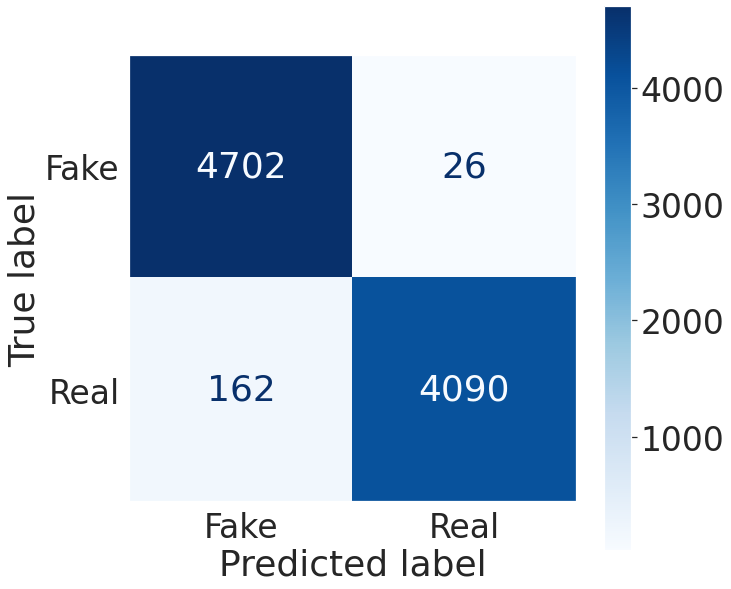

In [ ]:
sns.set(font_scale=3)
cm = confusion_matrix(list(y_test2), prediction2)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Fake','Real'])
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap = 'Blues')
plt.grid(b=None)
plt.show()

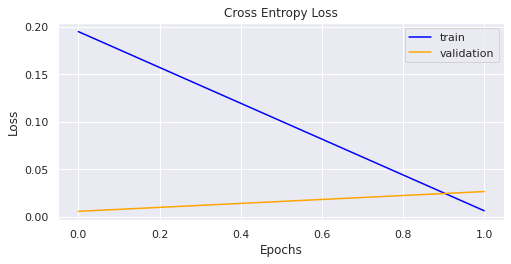

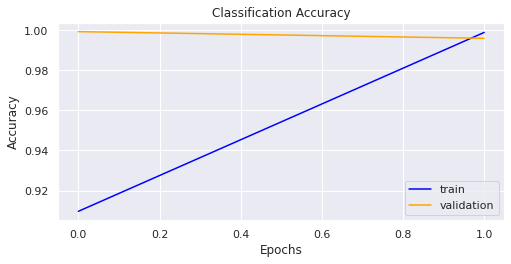

In [ ]:
## must run the line below to work
#LSTM_history = np.load('LSTM_history.npy',allow_pickle='TRUE').item()

sns.set(font_scale=1)
# plot loss
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(LSTM_history['loss'], color='blue', label='train')
plt.plot(LSTM_history['val_loss'], color='orange', label='validation')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Cross Entropy Loss')
plt.legend()
plt.show()

# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(LSTM_history['acc'], color='blue', label='train')
plt.plot(LSTM_history['val_acc'], color='orange', label='validation')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Classification Accuracy')
plt.legend()
plt.show()

# MODEL 3: BERT (BIDRECTIONAL ENCODER REPRESENTATIONS FROM TRANSFORMERS)

##### Followed Tensorflow tutorial for using Bert for text classification
##### https://www.tensorflow.org/text/tutorials/classify_text_with_bert


In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 29.2 MB/s 
     |████████████████████████████████| 462 kB 68.5 MB/s 
     |████████████████████████████████| 1.8 MB 32.2 MB/s 
     |████████████████████████████████| 352 kB 66.8 MB/s 
     |████████████████████████████████| 99 kB 11.6 MB/s 
     |████████████████████████████████| 1.1 MB 57.9 MB/s 
     |████████████████████████████████| 237 kB 69.6 MB/s 
     |████████████████████████████████| 596 kB 65.6 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 47.8 MB 55.7 MB/s 
     |████████████████████████████████| 1.2 MB 55.5 MB/s 
     |████████████████████████████████| 90 kB 11.6 MB/s 


In [ ]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)


model = tf.keras.models.Model(inputs=[text_input], outputs=[net], name='BERT')
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=["accuracy"])
model.summary()

Model: "BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                   

In [ ]:
# split data into test and train 
x_train3, x_test3, y_train3, y_test3 = train_test_split(data.clean_document, data.isReal, test_size = 0.2)

In [ ]:
# train the model
print(f'Training model with {tfhub_handle_encoder}')
BERT_history = model.fit(x_train3, y_train3, validation_split = 0.1, epochs = 2)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
1011/1011 [==============================] - 237s 229ms/step - loss: 0.0246 - accuracy: 0.9912 - val_loss: 0.0034 - val_accuracy: 0.9992
Epoch 2/2
1011/1011 [==============================] - 230s 227ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.0022 - val_accuracy: 0.9994


In [ ]:
# Save best model, already saved and included in zip file
#model.save("/content/drive/MyDrive/Term_Project_Dataset/BERT_model.h5")
#np.save('/content/drive/MyDrive/Term_Project_Dataset/BERT_history.npy',BERT_history.history)

In [ ]:
# Load best model
BERT_model = tf.keras.models.load_model("/content/drive/MyDrive/Term_Project_Dataset/BERT_model.h5", custom_objects={'KerasLayer':hub.KerasLayer})
BERT_history = np.load('/content/drive/MyDrive/Term_Project_Dataset/BERT_history.npy',allow_pickle='TRUE').item()

In [ ]:
# make prediction
pred3 = model.predict(x_test3)

In [ ]:
# if the predicted value is >0.5 it is real else it is fake
prediction3 = []
for i in range(len(pred3)):
    if pred3[i].item() > 0.5:
        prediction3.append(1)
    else:
        prediction3.append(0)

In [ ]:
accuracy3 = accuracy_score(list(y_test3), prediction3)
print("BERT Model Accuracy : ", accuracy3)

BERT Model Accuracy :  0.9985523385300669


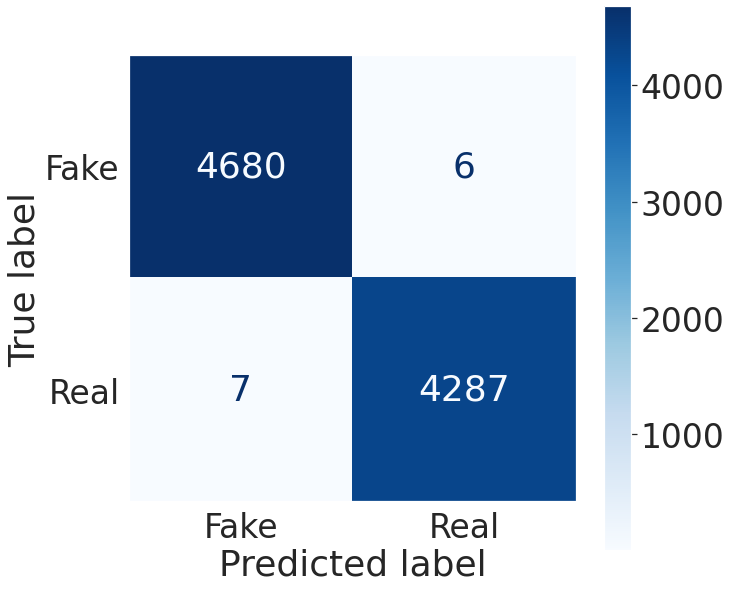

In [ ]:
sns.set(font_scale=3)
cm = confusion_matrix(list(y_test3), prediction3)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Fake','Real'])
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax, cmap = 'Blues')
plt.grid(b=None)
plt.show()

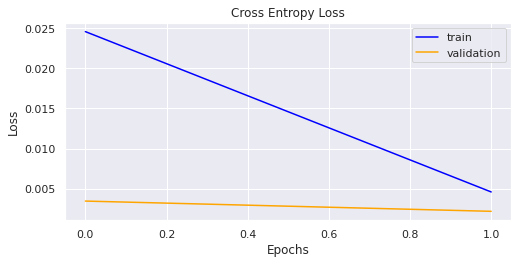

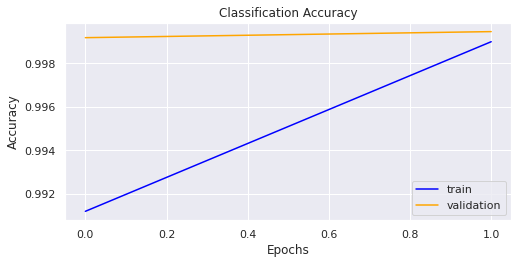

In [ ]:
## must run the line below to work
#BERT_history = np.load('BERT_history.npy',allow_pickle='TRUE').item()

# plot loss
sns.set(font_scale=1)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(BERT_history['loss'], color='blue', label='train')
plt.plot(BERT_history['val_loss'], color='orange', label='validation')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Cross Entropy Loss')
plt.legend()
plt.show()

# plot accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(BERT_history['accuracy'], color='blue', label='train')
plt.plot(BERT_history['val_accuracy'], color='orange', label='validation')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Classification Accuracy')
plt.legend()
plt.show()